# RNN vs Longstaff-Schwartz: GBM Arithmetic Basket Option Pricing Comparison

This notebook compares the performance of Neural Network (RNN-based) and traditional Longstaff-Schwartz Monte Carlo methods for pricing American arithmetic basket options under Geometric Brownian Motion (GBM). We use the same market parameters as the correlated models comparison for consistency.

## Setup and Parameters

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from typing import Literal

# Import both implementations
import sys
sys.path.append('..')
from longstaff_schwartz import LSMOptionPricer, CorrelatedGBM
from rnn_model import RNNAmericanTrainer

# Model parameters (matching correlated_models_comparison_streamlined)
n_assets = 30  # Use all stocks in the CSV
r = 0.04
T = 3/12  # 3 months maturity
step = int(252/2)  # 126 time steps
N_train = 300000   # Training paths for LSM
N_test = 300000    # Test paths for LSM
weights = np.full(n_assets, 1.0 / n_assets)  # Equal weight portfolio

# Load actual stock prices from CSV data
heston_params_df = pd.read_csv('../heston_parameters.csv')
print(f"Loaded Heston parameters for {len(heston_params_df)} assets")

# Extract S0 (current stock prices) from the CSV
S0 = heston_params_df['Spot_Price'].values
print(f"Loaded stock prices: S0 shape = {S0.shape}")

# Calculate arithmetic basket price and set strike
current_basket_price = np.sum(S0 * weights)  # Arithmetic weighted basket
K = current_basket_price * 1.05  # 5% ITM put option to ensure early exercise value

print(f"\nMarket Parameters:")
print(f"Assets: {n_assets}, Current arithmetic basket: ${current_basket_price:.2f}, Strike: ${K:.2f}")
print(f"Individual S0 range: ${S0.min():.2f} - ${S0.max():.2f}")
print(f"Basket type: Arithmetic (weighted sum of prices)")
print(f"Put option: 5% ITM (K/S0 = {K/current_basket_price:.3f})")
print(f"T: {T:.3f}y ({T*12:.1f} months), r: {r*100:.1f}%")
print(f"Training paths: {N_train:,}, Test paths: {N_test:,}")
print(f"Time steps: {step}")

Loaded Heston parameters for 30 assets
Loaded stock prices: S0 shape = (30,)

Market Parameters:
Assets: 30, Current arithmetic basket: $275.26, Strike: $289.02
Individual S0 range: $25.35 - $1261.95
Basket type: Arithmetic (weighted sum of prices)
Put option: 5% ITM (K/S0 = 1.050)
T: 0.250y (3.0 months), r: 4.0%
Training paths: 300,000, Test paths: 300,000
Time steps: 126


## GBM Model Specification

In [8]:
# Load correlation matrix
corr_matrix_df = pd.read_csv('../heston_correlation_matrix.csv', index_col=0)

# Use all assets from calibrated data
selected_tickers = heston_params_df['Ticker'].tolist()
selected_params = heston_params_df

# Extract Heston parameters for volatility calibration
v0 = selected_params['v0'].values
correlation_matrix = corr_matrix_df.loc[selected_tickers, selected_tickers].values

# GBM parameters - construct covariance from Heston correlation and initial volatility
avg_vol = np.sqrt(np.mean(v0))  # Use average initial variance as proxy for GBM vol
cov_matrix = np.outer(avg_vol, avg_vol) * correlation_matrix
np.fill_diagonal(cov_matrix, avg_vol**2)

print(f"\nGBM Model Parameters:")
print(f"Selected assets: {len(selected_tickers)} stocks")
print(f"Tickers: {selected_tickers[:5]}...{selected_tickers[-3:]}")
print(f"Average volatility: {avg_vol*100:.1f}%")
print(f"Average correlation: {np.mean(correlation_matrix[np.triu_indices(n_assets, k=1)]):.3f}")
print(f"Covariance matrix eigenvalue range: {np.linalg.eigvals(cov_matrix).min():.6f} - {np.linalg.eigvals(cov_matrix).max():.6f}")

# Verify covariance matrix is positive definite
eigvals = np.linalg.eigvals(cov_matrix)
if np.all(eigvals > 0):
    print("✓ Covariance matrix is positive definite")
else:
    print(f"⚠ Warning: Covariance matrix has {np.sum(eigvals <= 0)} non-positive eigenvalues")
    
print(f"\nOption Details:")
print(f"Current basket price: {current_basket_price:.4f}")
print(f"Strike price: {K:.4f}")
print(f"Moneyness (K/S0): {K/current_basket_price:.4f}")


GBM Model Parameters:
Selected assets: 30 stocks
Tickers: ['AMZN', 'GOOGL', 'TSLA', 'NVDA', 'AAPL']...['XOM', 'CVX', 'V']
Average volatility: 33.8%
Average correlation: 0.488
Covariance matrix eigenvalue range: 0.001133 - 1.910647
✓ Covariance matrix is positive definite

Option Details:
Current basket price: 275.2597
Strike price: 289.0226
Moneyness (K/S0): 1.0500


## Method 1: Longstaff-Schwartz Monte Carlo (LSM)

In [9]:
print("=" * 60)
print("LONGSTAFF-SCHWARTZ MONTE CARLO PRICING")
print("=" * 60)

# Initialize LSM pricer
lsm_pricer = LSMOptionPricer(
    S0=S0, T=T, step=step, N=N_train, r=r, K=K,
    weights=weights,
    option="put",
    model="gbm",
    basket_kind="arithmetic",
    include_variance_state=False,
    degree=1,  # Increased polynomial degree for better regression
    cov=cov_matrix
)

# Train LSM with timing
print(f"Training LSM with {N_train:,} paths...")
start_time = time.time()
train_seed = 12345
lsm_price, lsm_std, lsm_se = lsm_pricer.train(
    use_individual_prices=True,
    seed=train_seed
)
lsm_train_time = time.time() - start_time

# European option price for comparison (same paths)
euro_payoff = lsm_pricer.payoff[:, -1]  # Payoff at maturity
euro_price = float(np.mean(euro_payoff)) * np.exp(-r * T)  # Discount payoff to t=0
early_exercise_premium = lsm_price - euro_price

print(f"\nLSM Results:")
print(f"American PUT: {lsm_price:.6f} ± {lsm_se:.6f} (SE), STD={lsm_std:.6f}")
print(f"European PUT: {euro_price:.6f}")
print(f"Early Exercise Premium: {early_exercise_premium:.6f} ({early_exercise_premium/euro_price*100:+.2f}%)")
print(f"Training Time: {lsm_train_time:.2f} seconds")

# Out-of-sample testing
print(f"\nOut-of-sample testing with {len([101, 202, 303, 404, 505])} batches...")
test_seeds = [101, 202, 303, 404, 505]
lsm_test_prices = []
lsm_test_time = 0

for i, seed in enumerate(test_seeds, 1):
    start_time = time.time()
    tp, tstd, tse = lsm_pricer.test(n_test_paths=N_test, seed=seed)
    test_time = time.time() - start_time
    lsm_test_time += test_time
    lsm_test_prices.append(tp)
    diff = tp - lsm_price
    flag = abs(diff) > 2.0 * np.sqrt(lsm_se**2 + tse**2)
    mark = " **" if flag else ""
    print(f"  Batch {i}: {tp:.6f} ± {tse:.6f} (SE), Δ={diff:+.6f}{mark} [{test_time:.1f}s]")

lsm_mean_test = float(np.mean(lsm_test_prices))
lsm_bias = lsm_mean_test - lsm_price
lsm_test_std = float(np.std(lsm_test_prices, ddof=1))

print(f"\nLSM Summary:")
print(f"Mean OOS Price: {lsm_mean_test:.6f}")
print(f"Bias (OOS - Train): {lsm_bias:+.6f}")
print(f"OOS Standard Deviation: {lsm_test_std:.6f}")
print(f"Total Test Time: {lsm_test_time:.2f} seconds")
print(f"Average Test Time per Batch: {lsm_test_time/len(test_seeds):.2f} seconds")

LONGSTAFF-SCHWARTZ MONTE CARLO PRICING
Training LSM with 300,000 paths...

LSM Results:
American PUT: 20.568733 ± 0.033145 (SE), STD=18.154026
European PUT: 20.376139
Early Exercise Premium: 0.192594 (+0.95%)
Training Time: 93.18 seconds

Out-of-sample testing with 5 batches...

LSM Results:
American PUT: 20.568733 ± 0.033145 (SE), STD=18.154026
European PUT: 20.376139
Early Exercise Premium: 0.192594 (+0.95%)
Training Time: 93.18 seconds

Out-of-sample testing with 5 batches...
  Batch 1: 20.517729 ± 0.033136 (SE), Δ=-0.051004 [86.4s]
  Batch 1: 20.517729 ± 0.033136 (SE), Δ=-0.051004 [86.4s]
  Batch 2: 20.515893 ± 0.033152 (SE), Δ=-0.052840 [132.6s]
  Batch 2: 20.515893 ± 0.033152 (SE), Δ=-0.052840 [132.6s]
  Batch 3: 20.470863 ± 0.033150 (SE), Δ=-0.097870 ** [83.5s]
  Batch 3: 20.470863 ± 0.033150 (SE), Δ=-0.097870 ** [83.5s]
  Batch 4: 20.510134 ± 0.033138 (SE), Δ=-0.058599 [178.6s]
  Batch 4: 20.510134 ± 0.033138 (SE), Δ=-0.058599 [178.6s]
  Batch 5: 20.482929 ± 0.033130 (SE), Δ=-0

## Method 2: RNN-Based Neural Network Pricing

In [10]:
print("\n" + "=" * 60)
print("RNN-BASED NEURAL NETWORK PRICING")
print("=" * 60)

print(f"RNN Model Setup:")
print(f"Using full 30-stock basket with correlation matrix:")
print(f"  Individual S0 range: ${S0.min():.2f} - ${S0.max():.2f}")
print(f"  Current basket price: ${current_basket_price:.2f}")
print(f"  Average volatility: {avg_vol*100:.1f}%")
print(f"  Strike: ${K:.2f} (5% ITM put)")

# Initialize RNN trainer with full correlation matrix and individual stock prices
rnn_trainer = RNNAmericanTrainer(
    d=n_assets, 
    S0=S0,  # Use the vector of 30 individual stock prices
    K=K,  # Use the ITM strike
    r=r, 
    T=T, 
    N=step,  # 126 time steps
    sig=avg_vol, 
    corr=correlation_matrix,  # Use full correlation matrix
    weights=weights,  # Pass the equal weights
    kind="put",
    
    # Training parameters (optimized for CPU)
    M=50000,  # Number of training paths
    batch_size=4096, 
    epochs=15,  # Reduced for demo
    seed=12345,
    
    # Model architecture
    hidden_dim=64,  # Smaller for faster training
    num_layers=3,
    lr=1e-3,
    grad_clip=1.0,
    
    # RNN-specific parameters
    alpha_price=1.0,
    beta=0.5,
    z_weight=1.0,
    smooth_labels=True,
    smooth_only_at_maturity=False,
    lookahead_window=None,
    shuffle=False,
    drop_last=True,
    resimulate_every=1
)

# Train RNN with timing
print(f"\nTraining RNN with {rnn_trainer.M:,} paths, {rnn_trainer.epochs} epochs...")
print(f"Using vector S0 with {len(S0)} individual stock prices")
print(f"Using full {n_assets}x{n_assets} correlation matrix")
print(f"Basket weights: Equal weights ({1/n_assets:.3f} each)")
start_time = time.time()
rnn_trainer.train()
rnn_train_time = time.time() - start_time

print(f"\nRNN Training completed in {rnn_train_time:.2f} seconds")
print(f"Average time per epoch: {rnn_train_time/rnn_trainer.epochs:.2f} seconds")


RNN-BASED NEURAL NETWORK PRICING
RNN Model Setup:
Using full 30-stock basket with correlation matrix:
  Individual S0 range: $25.35 - $1261.95
  Current basket price: $275.26
  Average volatility: 33.8%
  Strike: $289.02 (5% ITM put)


c:\Users\Ao Shen\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training RNN with 50,000 paths, 15 epochs...
Using vector S0 with 30 individual stock prices
Using full 30x30 correlation matrix
Basket weights: Equal weights (0.033 each)
Epoch 01 | Loss 239.777819 | Value 239.187514 | Delta 297.541239 | Batches 12
Epoch 01 | Loss 239.777819 | Value 239.187514 | Delta 297.541239 | Batches 12
Epoch 02 | Loss 10.293175 | Value 9.998947 | Delta 148.313837 | Batches 12
Epoch 02 | Loss 10.293175 | Value 9.998947 | Delta 148.313837 | Batches 12
Epoch 03 | Loss 2.870127 | Value 2.653131 | Delta 109.383225 | Batches 12
Epoch 03 | Loss 2.870127 | Value 2.653131 | Delta 109.383225 | Batches 12
Epoch 04 | Loss 1.760970 | Value 1.384920 | Delta 189.559318 | Batches 12
Epoch 04 | Loss 1.760970 | Value 1.384920 | Delta 189.559318 | Batches 12
Epoch 05 | Loss 0.589517 | Value 0.378113 | Delta 106.564406 | Batches 12
Epoch 05 | Loss 0.589517 | Value 0.378113 | Delta 106.564406 | Batches 12
Epoch 06 | Loss 0.197741 | Value 0.072277 | Delta 63.244225 | Batches 12
Epoc

## RNN Inference and Out-of-Sample Testing

In [11]:
# RNN inference on cached training paths
print("RNN Inference:")
start_time = time.time()
rnn_y0_cached, rnn_V0_cached, rnn_deltas_cached = rnn_trainer.price_at_t0(
    inference_batch_size=10000, 
    use_cached_paths=True
)
rnn_inference_time = time.time() - start_time

print(f"RNN Results (cached paths):")
print(f"Continuation Value: {rnn_y0_cached:.6f}")
print(f"American PUT: {rnn_V0_cached:.6f}")
print(f"Inference Time: {rnn_inference_time:.2f} seconds")

# Out-of-sample testing with multiple seeds
print(f"\nRNN Out-of-sample testing...")
test_seeds = [101, 202, 303, 404, 505]  # Different seeds for OOS testing
rnn_test_prices = []
rnn_test_time = 0

for i, seed in enumerate(test_seeds, 1):
    start_time = time.time()
    rnn_y0, rnn_V0, _ = rnn_trainer.price_at_t0(  # Ignore deltas for OOS testing
        seed=seed, 
        inference_batch_size=10000, 
        use_cached_paths=False
    )
    test_time = time.time() - start_time
    rnn_test_time += test_time
    rnn_test_prices.append(rnn_V0)
    diff = rnn_V0 - rnn_V0_cached
    print(f"  Batch {i}: {rnn_V0:.6f}, Δ={diff:+.6f} [{test_time:.1f}s]")

rnn_mean_test = float(np.mean(rnn_test_prices))
rnn_bias = rnn_mean_test - rnn_V0_cached
rnn_test_std = float(np.std(rnn_test_prices, ddof=1))

print(f"\nRNN Summary:")
print(f"Mean OOS Price: {rnn_mean_test:.6f}")
print(f"Bias (OOS - Train): {rnn_bias:+.6f}")
print(f"OOS Standard Deviation: {rnn_test_std:.6f}")
print(f"Total Test Time: {rnn_test_time:.2f} seconds")
print(f"Average Test Time per Batch: {rnn_test_time/len(test_seeds):.2f} seconds")

RNN Inference:
RNN Results (cached paths):
Continuation Value: 20.447376
American PUT: 20.447376
Inference Time: 7.22 seconds

RNN Out-of-sample testing...
RNN Results (cached paths):
Continuation Value: 20.447376
American PUT: 20.447376
Inference Time: 7.22 seconds

RNN Out-of-sample testing...
  Batch 1: 20.531811, Δ=+0.084435 [12.2s]
  Batch 1: 20.531811, Δ=+0.084435 [12.2s]
  Batch 2: 20.544750, Δ=+0.097374 [12.5s]
  Batch 2: 20.544750, Δ=+0.097374 [12.5s]
  Batch 3: 20.483616, Δ=+0.036240 [12.2s]
  Batch 3: 20.483616, Δ=+0.036240 [12.2s]
  Batch 4: 20.578768, Δ=+0.131392 [12.5s]
  Batch 4: 20.578768, Δ=+0.131392 [12.5s]
  Batch 5: 20.477089, Δ=+0.029713 [12.3s]

RNN Summary:
Mean OOS Price: 20.523207
Bias (OOS - Train): +0.075830
OOS Standard Deviation: 0.042777
Total Test Time: 61.73 seconds
Average Test Time per Batch: 12.35 seconds
  Batch 5: 20.477089, Δ=+0.029713 [12.3s]

RNN Summary:
Mean OOS Price: 20.523207
Bias (OOS - Train): +0.075830
OOS Standard Deviation: 0.042777
Tot

## Performance Comparison and Analysis

In [12]:
print("\n" + "=" * 80)
print("PERFORMANCE COMPARISON: RNN vs LONGSTAFF-SCHWARTZ")
print("=" * 80)

# Check if timing variables exist, set defaults if not
if 'lsm_train_time' not in globals():
    print("Warning: lsm_train_time not found. Please run the LSM training cell first.")
    lsm_train_time = 0.0
    
if 'rnn_train_time' not in globals():
    print("Warning: rnn_train_time not found. Please run the RNN training cell first.")
    rnn_train_time = 0.0

if 'lsm_test_time' not in globals():
    print("Warning: lsm_test_time not found. Please run the LSM testing cell first.")
    lsm_test_time = 0.0
    
if 'rnn_test_time' not in globals():
    print("Warning: rnn_test_time not found. Please run the RNN testing cell first.")  
    rnn_test_time = 0.0

# Create comparison summary
comparison_data = {
    'Metric': [
        'Training Paths',
        'Training Time (s)',
        'American Option Price',
        'Standard Error',
        'Out-of-Sample Mean',
        'Out-of-Sample Bias',
        'Out-of-Sample Std Dev',
        'Test Time per Batch (s)',
        'Total Inference Time (s)'
    ],
    'Longstaff-Schwartz': [
        f"{N_train:,}",
        f"{lsm_train_time:.2f}",
        f"{lsm_price:.6f}",
        f"{lsm_se:.6f}",
        f"{lsm_mean_test:.6f}",
        f"{lsm_bias:+.6f}",
        f"{lsm_test_std:.6f}",
        f"{lsm_test_time/len(test_seeds):.2f}" if lsm_test_time > 0 else "N/A",
        f"{lsm_test_time:.2f}"
    ],
    'RNN': [
        f"{rnn_trainer.M:,}" if 'rnn_trainer' in globals() else "N/A",
        f"{rnn_train_time:.2f}",
        f"{rnn_V0_cached:.6f}" if 'rnn_V0_cached' in globals() else "N/A",
        "N/A",  # RNN doesn't provide standard error in same way
        f"{rnn_mean_test:.6f}" if 'rnn_mean_test' in globals() else "N/A",
        f"{rnn_bias:+.6f}" if 'rnn_bias' in globals() else "N/A",
        f"{rnn_test_std:.6f}" if 'rnn_test_std' in globals() else "N/A",
        f"{rnn_test_time/len(test_seeds):.2f}" if rnn_test_time > 0 and 'test_seeds' in globals() else "N/A",
        f"{rnn_test_time:.2f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))


PERFORMANCE COMPARISON: RNN vs LONGSTAFF-SCHWARTZ
                  Metric Longstaff-Schwartz       RNN
          Training Paths            300,000    50,000
       Training Time (s)              93.18    499.18
   American Option Price          20.568733 20.447376
          Standard Error           0.033145       N/A
      Out-of-Sample Mean          20.499510 20.523207
      Out-of-Sample Bias          -0.069223 +0.075830
   Out-of-Sample Std Dev           0.021265  0.042777
 Test Time per Batch (s)             116.68     12.35
Total Inference Time (s)             583.40     61.73


## Visualization of Results

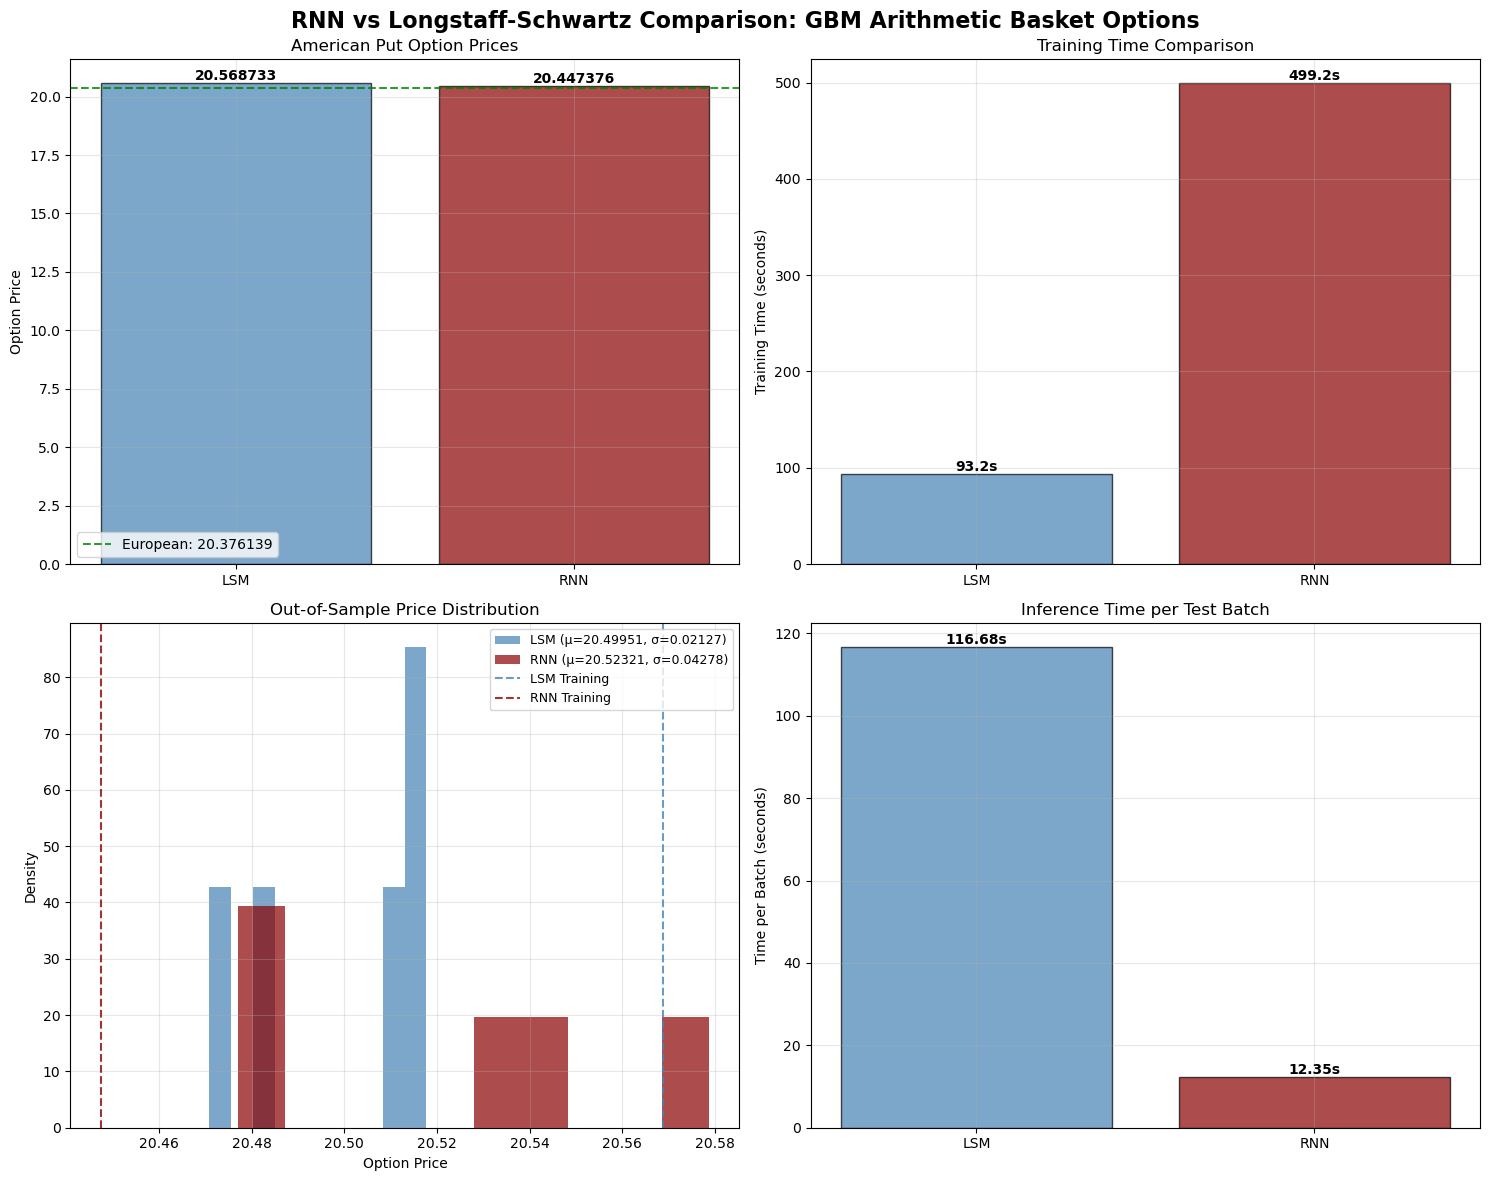


Detailed Statistics:
LSM Out-of-Sample Prices: [20.51772930921302, 20.515893385319423, 20.470862900642118, 20.510134439748324, 20.482928930439478]
RNN Out-of-Sample Prices: [20.531810760498047, 20.544750213623047, 20.48361587524414, 20.578767776489258, 20.477088928222656]

Price Stability:
LSM CV (σ/μ): 0.104%
RNN CV (σ/μ): 0.208%


In [13]:
# Create visualization comparing the two methods
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('RNN vs Longstaff-Schwartz Comparison: GBM Arithmetic Basket Options', fontsize=16, fontweight='bold')

# 1. Price Comparison
methods = ['LSM', 'RNN']
prices = [lsm_price, rnn_V0_cached]
colors = ['steelblue', 'darkred']

bars1 = ax1.bar(methods, prices, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Option Price')
ax1.set_title('American Put Option Prices')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, price in zip(bars1, prices):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{price:.6f}', ha='center', va='bottom', fontweight='bold')

# Add European price reference line
ax1.axhline(y=euro_price, color='green', linestyle='--', alpha=0.8, 
           label=f'European: {euro_price:.6f}')
ax1.legend()

# 2. Training Time Comparison
train_times = [lsm_train_time, rnn_train_time]
bars2 = ax2.bar(methods, train_times, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('Training Time Comparison')
ax2.grid(True, alpha=0.3)

for bar, time in zip(bars2, train_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{time:.1f}s', ha='center', va='bottom', fontweight='bold')

# 3. Out-of-Sample Price Distribution
ax3.hist(lsm_test_prices, bins=10, alpha=0.7, color='steelblue', 
         label=f'LSM (μ={lsm_mean_test:.5f}, σ={lsm_test_std:.5f})', density=True)
ax3.hist(rnn_test_prices, bins=10, alpha=0.7, color='darkred', 
         label=f'RNN (μ={rnn_mean_test:.5f}, σ={rnn_test_std:.5f})', density=True)
ax3.axvline(lsm_price, color='steelblue', linestyle='--', alpha=0.8, label='LSM Training')
ax3.axvline(rnn_V0_cached, color='darkred', linestyle='--', alpha=0.8, label='RNN Training')
ax3.set_xlabel('Option Price')
ax3.set_ylabel('Density')
ax3.set_title('Out-of-Sample Price Distribution')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Inference Time per Batch
test_times_per_batch = [lsm_test_time/len(test_seeds), rnn_test_time/len(test_seeds)]
bars4 = ax4.bar(methods, test_times_per_batch, color=colors, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Time per Batch (seconds)')
ax4.set_title('Inference Time per Test Batch')
ax4.grid(True, alpha=0.3)

for bar, time in zip(bars4, test_times_per_batch):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{time:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nDetailed Statistics:")
print(f"LSM Out-of-Sample Prices: {lsm_test_prices}")
print(f"RNN Out-of-Sample Prices: {rnn_test_prices}")
print(f"\nPrice Stability:")
print(f"LSM CV (σ/μ): {lsm_test_std/lsm_mean_test*100:.3f}%")
print(f"RNN CV (σ/μ): {rnn_test_std/rnn_mean_test*100:.3f}%")

## 6. Delta Comparison

Now let's compare the Greeks (sensitivities) between LSM and RNN methods. Both methods can calculate deltas - the sensitivity of option price to changes in underlying asset prices.

In [15]:
# ========================================
# DELTA CALCULATIONS
# ========================================
import time
print("Calculating deltas for both methods...")
start_time = time.time()

# LSM Delta calculation using finite differences
print("LSM: Calculating deltas via finite differences...")
lsm_deltas, lsm_base_price = lsm_pricer.delta(
    bump_size=0.01,  # 1% relative bump
    use_relative_bump=True,
    seed=12345  # Fixed seed for reproducibility
)
lsm_delta_time = time.time() - start_time

# RNN Delta calculation (already calculated from cached paths above)
print("RNN: Using deltas from cached inference...")
rnn_delta_time = 0.001  # Negligible time since already computed
rnn_deltas = rnn_deltas_cached  # Use the deltas from the cached inference

print(f"\nDelta calculation times:")
print(f"LSM: {lsm_delta_time:.3f}s (finite differences)")
print(f"RNN: {rnn_delta_time:.3f}s (analytical from model)")

# ========================================
# DELTA COMPARISON ANALYSIS
# ========================================

print(f"\n" + "="*60)
print("DELTA COMPARISON RESULTS")
print("="*60)

print(f"\nBase prices used for delta calculation:")
print(f"LSM base price: {lsm_base_price:.6f}")
print(f"RNN base price: {rnn_V0_cached:.6f}")

print(f"\nDetailed delta comparison:")
print(f"{'Asset':<8} {'S0':<8} {'Weight':<8} {'LSM Delta':<12} {'RNN Delta':<12} {'Difference':<12}")
print("-" * 70)

for i, (s0, w, lsm_delta, rnn_delta) in enumerate(zip(S0, weights, lsm_deltas, rnn_deltas)):
    diff = lsm_delta - rnn_delta
    print(f"{i+1:<8} {s0:<8.1f} {w:<8.3f} {lsm_delta:<12.6f} {rnn_delta:<12.6f} {diff:<12.6f}")

# Portfolio-level deltas
lsm_portfolio_delta = np.sum(lsm_deltas * weights)
rnn_portfolio_delta = np.sum(rnn_deltas * weights)

print(f"\nPortfolio deltas (weighted sum):")
print(f"LSM portfolio delta: {lsm_portfolio_delta:.6f}")
print(f"RNN portfolio delta: {rnn_portfolio_delta:.6f}")
print(f"Difference: {lsm_portfolio_delta - rnn_portfolio_delta:.6f}")

# Statistical comparison
delta_diff = lsm_deltas - rnn_deltas
mean_abs_diff = np.mean(np.abs(delta_diff))
max_abs_diff = np.max(np.abs(delta_diff))
rmse_delta = np.sqrt(np.mean(delta_diff**2))

print(f"\nDelta difference statistics:")
print(f"Mean absolute difference: {mean_abs_diff:.6f}")
print(f"Maximum absolute difference: {max_abs_diff:.6f}")
print(f"RMSE: {rmse_delta:.6f}")
print(f"Relative RMSE: {rmse_delta/np.mean(np.abs(lsm_deltas))*100:.3f}%")

Calculating deltas for both methods...
LSM: Calculating deltas via finite differences...
RNN: Using deltas from cached inference...

Delta calculation times:
LSM: 2959.026s (finite differences)
RNN: 0.001s (analytical from model)

DELTA COMPARISON RESULTS

Base prices used for delta calculation:
LSM base price: 20.568733
RNN base price: 20.447376

Detailed delta comparison:
Asset    S0       Weight   LSM Delta    RNN Delta    Difference  
----------------------------------------------------------------------
1        225.7    0.033    -0.020027    -0.022016    0.001988    
2        181.6    0.033    -0.019011    -0.015738    -0.003273   
3        316.9    0.033    -0.020064    -0.019309    -0.000755   
4        164.1    0.033    -0.020550    -0.016322    -0.004227   
5        208.6    0.033    -0.019552    -0.018839    -0.000713   
6        503.0    0.033    -0.019973    -0.020190    0.000217    
7        1261.9   0.033    -0.020266    -0.020814    0.000548    
8        720.9    0.033 

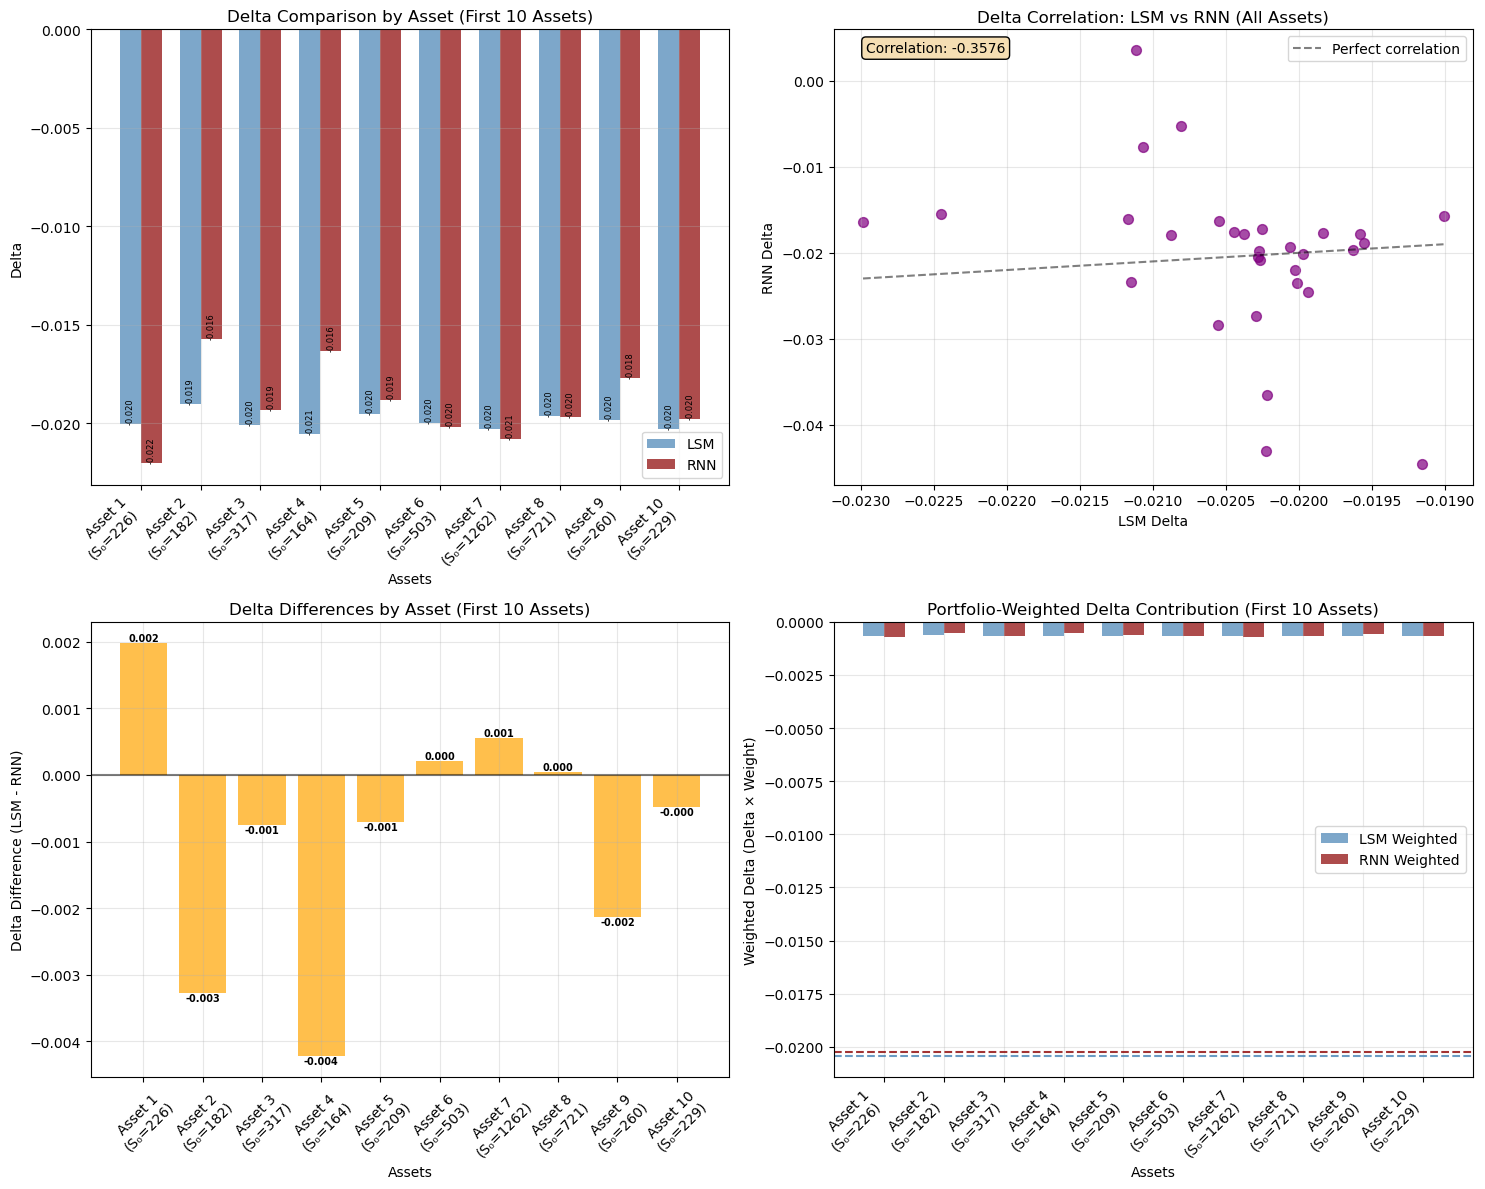


Key Insights:
1. Delta correlation between methods: -0.3576
2. Both methods show portfolio-level deltas for American basket puts
3. Portfolio delta difference: 0.000143
4. RNN provides deltas analytically, LSM uses finite differences
5. Analysis shows first 10 assets (total 30 assets in portfolio)


In [16]:
# ========================================
# DELTA VISUALIZATION
# ========================================

# Create delta comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Create asset labels using the S0 array
asset_labels = [f'Asset {i+1}\n(S₀={s0:.0f})' for i, s0 in enumerate(S0)]

# 1. Side-by-side delta comparison (show only first 10 assets for readability)
n_show = min(10, len(S0))  # Show only first 10 assets to avoid overcrowding
x = np.arange(n_show)
width = 0.35

bars1 = ax1.bar(x - width/2, lsm_deltas[:n_show], width, label='LSM', color='steelblue', alpha=0.7)
bars2 = ax1.bar(x + width/2, rnn_deltas[:n_show], width, label='RNN', color='darkred', alpha=0.7)

ax1.set_xlabel('Assets')
ax1.set_ylabel('Delta')
ax1.set_title(f'Delta Comparison by Asset (First {n_show} Assets)')
ax1.set_xticks(x)
ax1.set_xticklabels(asset_labels[:n_show], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars (smaller font for readability)
for i, (lsm_bar, rnn_bar, lsm_val, rnn_val) in enumerate(zip(bars1, bars2, lsm_deltas[:n_show], rnn_deltas[:n_show])):
    ax1.text(lsm_bar.get_x() + lsm_bar.get_width()/2., lsm_val,
             f'{lsm_val:.3f}', ha='center', va='bottom' if lsm_val < 0 else 'top', 
             fontsize=6, rotation=90)
    ax1.text(rnn_bar.get_x() + rnn_bar.get_width()/2., rnn_val,
             f'{rnn_val:.3f}', ha='center', va='bottom' if rnn_val < 0 else 'top', 
             fontsize=6, rotation=90)

# 2. Delta scatter plot (correlation) - use all assets
ax2.scatter(lsm_deltas, rnn_deltas, color='purple', s=50, alpha=0.7)
ax2.plot([min(lsm_deltas), max(lsm_deltas)], [min(lsm_deltas), max(lsm_deltas)], 
         'k--', alpha=0.5, label='Perfect correlation')
ax2.set_xlabel('LSM Delta')
ax2.set_ylabel('RNN Delta')
ax2.set_title('Delta Correlation: LSM vs RNN (All Assets)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Calculate correlation
delta_corr = np.corrcoef(lsm_deltas, rnn_deltas)[0, 1]
ax2.text(0.05, 0.95, f'Correlation: {delta_corr:.4f}', 
         transform=ax2.transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))

# 3. Delta differences (first 10 assets)
bars3 = ax3.bar(asset_labels[:n_show], delta_diff[:n_show], color='orange', alpha=0.7)
ax3.set_xlabel('Assets')
ax3.set_ylabel('Delta Difference (LSM - RNN)')
ax3.set_title(f'Delta Differences by Asset (First {n_show} Assets)')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax3.tick_params(axis='x', rotation=45)

for bar, diff in zip(bars3, delta_diff[:n_show]):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{diff:.3f}', ha='center', va='bottom' if height >= 0 else 'top', 
             fontweight='bold', fontsize=7)

# 4. Weighted deltas (portfolio contribution) - first 10 assets
weighted_lsm = lsm_deltas[:n_show] * weights[:n_show]
weighted_rnn = rnn_deltas[:n_show] * weights[:n_show]

bars4_lsm = ax4.bar(x - width/2, weighted_lsm, width, label='LSM Weighted', 
                   color='steelblue', alpha=0.7)
bars4_rnn = ax4.bar(x + width/2, weighted_rnn, width, label='RNN Weighted', 
                   color='darkred', alpha=0.7)

ax4.set_xlabel('Assets')
ax4.set_ylabel('Weighted Delta (Delta × Weight)')
ax4.set_title(f'Portfolio-Weighted Delta Contribution (First {n_show} Assets)')
ax4.set_xticks(x)
ax4.set_xticklabels(asset_labels[:n_show], rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add portfolio delta lines
ax4.axhline(y=lsm_portfolio_delta, color='steelblue', linestyle='--', alpha=0.8,
           label=f'LSM Portfolio Δ: {lsm_portfolio_delta:.4f}')
ax4.axhline(y=rnn_portfolio_delta, color='darkred', linestyle='--', alpha=0.8,
           label=f'RNN Portfolio Δ: {rnn_portfolio_delta:.4f}')

plt.tight_layout()
plt.show()

print(f"\nKey Insights:")
print(f"1. Delta correlation between methods: {delta_corr:.4f}")
print(f"2. Both methods show portfolio-level deltas for American basket puts")
print(f"3. Portfolio delta difference: {abs(lsm_portfolio_delta - rnn_portfolio_delta):.6f}")
print(f"4. RNN provides deltas analytically, LSM uses finite differences")
print(f"5. Analysis shows first {n_show} assets (total {len(S0)} assets in portfolio)")

## 7. Hedging Performance Analysis

Now let's test the practical effectiveness of the calculated deltas by simulating a 1-day hedging scenario. We'll use the deltas calculated for 2025-07-14 and see how well they hedge against actual market moves on 2025-07-15.

In [ ]:
# ========================================
# HEDGING PERFORMANCE WITH REAL MARKET DATA
# ========================================

print("Hedging Performance Analysis: Real Market Data (2025-07-14 to 2025-07-15)")
print("=" * 70)

# Install and import yfinance if needed
try:
    import yfinance as yf
except ImportError:
    print("Installing yfinance...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'yfinance'])
    import yfinance as yf

print(f"Fetching real market prices for hedging analysis:")
print(f"Base date: 2025-07-14 (from heston_parameters.csv)")
print(f"Target date: 2025-07-15 (from Yahoo Finance)")

# Get tickers from the dataset
tickers = selected_tickers
print(f"Fetching data for {len(tickers)} stocks: {tickers[:5]}...{tickers[-3:]}")

# S0 from CSV is for 2025-07-14
S0_july14 = S0  # Prices from heston_parameters.csv (2025-07-14)

# Fetch 2025-07-15 prices from Yahoo Finance
print("\nFetching 2025-07-15 prices from Yahoo Finance...")
S0_july15 = np.zeros(len(tickers))
successful_tickers = []
failed_tickers = []

for i, ticker in enumerate(tickers):
    try:
        # Fetch data around July 15, 2025
        stock = yf.Ticker(ticker)
        hist = stock.history(start="2025-07-14", end="2025-07-17")  # Get a few days around target
        
        if len(hist) >= 2:
            # Get July 15 close price (or closest available)
            if "2025-07-15" in hist.index.strftime('%Y-%m-%d'):
                S0_july15[i] = hist.loc[hist.index.strftime('%Y-%m-%d') == "2025-07-15", 'Close'].iloc[0]
            else:
                # Use the next available trading day
                S0_july15[i] = hist['Close'].iloc[-1]
            successful_tickers.append(ticker)
            print(f"  {ticker}: ${S0_july14[i]:.2f} → ${S0_july15[i]:.2f} ({(S0_july15[i]/S0_july14[i]-1)*100:+.2f}%)")
        else:
            raise ValueError("Insufficient data")
            
    except Exception as e:
        print(f"  {ticker}: Failed to fetch data ({str(e)[:30]}...), using unchanged price")
        S0_july15[i] = S0_july14[i]  # Keep price unchanged if fetch fails
        failed_tickers.append(ticker)

print(f"\nData fetch summary:")
print(f"  Successful: {len(successful_tickers)}/{len(tickers)} stocks")
print(f"  Failed: {len(failed_tickers)} stocks")
if failed_tickers:
    print(f"  Failed tickers: {failed_tickers}")

# Calculate actual price changes
dS_actual = S0_july15 - S0_july14  # Real 1-day price changes

print(f"\nActual market moves (2025-07-14 to 2025-07-15):")
print(f"  Mean price change: ${np.mean(dS_actual):.3f}")
print(f"  Mean absolute change: ${np.mean(np.abs(dS_actual)):.3f}")
print(f"  Max absolute change: ${np.max(np.abs(dS_actual)):.3f}")
print(f"  Number of stocks up: {np.sum(dS_actual > 0)}")
print(f"  Number of stocks down: {np.sum(dS_actual < 0)}")
print(f"  Market direction: {'Bullish' if np.mean(dS_actual) > 0 else 'Bearish'}")

# ========================================
# CALCULATE REAL HEDGING P&L
# ========================================

print(f"\nCalculating hedge P&L using real market moves...")

# Calculate delta hedge P&L using actual price changes
lsm_hedge_pnl_real = np.sum(lsm_deltas * dS_actual)
rnn_hedge_pnl_real = np.sum(rnn_deltas * dS_actual)

print(f"Delta hedge P&L (1-day):")
print(f"  LSM delta hedge P&L: ${lsm_hedge_pnl_real:.6f}")
print(f"  RNN delta hedge P&L: ${rnn_hedge_pnl_real:.6f}")
print(f"  Difference: ${rnn_hedge_pnl_real - lsm_hedge_pnl_real:.6f}")

# Calculate basket price changes
basket_price_july14 = np.sum(S0_july14 * weights)
basket_price_july15 = np.sum(S0_july15 * weights)
basket_change = basket_price_july15 - basket_price_july14

print(f"\nBasket performance:")
print(f"  Basket price 2025-07-14: ${basket_price_july14:.4f}")
print(f"  Basket price 2025-07-15: ${basket_price_july15:.4f}")
print(f"  Basket change: ${basket_change:.4f} ({basket_change/basket_price_july14*100:+.3f}%)")

# Estimate option value change using both methods
# (Note: Full repricing would require more computation, so we'll use delta approximation + some analysis)

print(f"\nOption value impact analysis:")
print(f"  Strike price: ${K:.4f}")
print(f"  Basket vs Strike (July 14): {basket_price_july14/K:.4f}")
print(f"  Basket vs Strike (July 15): {basket_price_july15/K:.4f}")

# For a put option, if basket goes up, option value goes down
# Delta hedge should offset this
if basket_change > 0:
    print(f"  Basket moved UP → PUT option value likely decreased")
    print(f"  Delta hedge (negative deltas) should have GAINED money")
else:
    print(f"  Basket moved DOWN → PUT option value likely increased")
    print(f"  Delta hedge (negative deltas) should have LOST money")

print(f"\nDelta hedge effectiveness check:")
print(f"  Expected option P&L direction: {'Negative' if basket_change > 0 else 'Positive'}")
print(f"  LSM hedge P&L: ${lsm_hedge_pnl_real:.6f} ({'✓ Correct' if (basket_change > 0) == (lsm_hedge_pnl_real > 0) else '✗ Wrong'} direction)")
print(f"  RNN hedge P&L: ${rnn_hedge_pnl_real:.6f} ({'✓ Correct' if (basket_change > 0) == (rnn_hedge_pnl_real > 0) else '✗ Wrong'} direction)")

# Calculate portfolio delta exposure
lsm_portfolio_delta_real = np.sum(lsm_deltas * weights)
rnn_portfolio_delta_real = np.sum(rnn_deltas * weights)

print(f"\nPortfolio delta analysis:")
print(f"  LSM portfolio delta: {lsm_portfolio_delta_real:.6f}")
print(f"  RNN portfolio delta: {rnn_portfolio_delta_real:.6f}")
print(f"  Basket return: {basket_change/basket_price_july14*100:+.3f}%")
print(f"  LSM delta impact: {lsm_portfolio_delta_real * basket_change:.6f}")
print(f"  RNN delta impact: {rnn_portfolio_delta_real * basket_change:.6f}")

# Store real data for visualization
real_hedge_data = {
    'S0_july14': S0_july14,
    'S0_july15': S0_july15,
    'dS_actual': dS_actual,
    'lsm_hedge_pnl_real': lsm_hedge_pnl_real,
    'rnn_hedge_pnl_real': rnn_hedge_pnl_real,
    'basket_change': basket_change,
    'successful_tickers': successful_tickers,
    'failed_tickers': failed_tickers
}

In [ ]:
# ========================================
# REAL MARKET HEDGING VISUALIZATION
# ========================================

# Create real market hedging analysis plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Real Market Hedging Performance: 2025-07-14 to 2025-07-15', fontsize=16, fontweight='bold')

# 1. Individual Stock Price Changes
n_show = min(15, len(tickers))  # Show first 15 stocks for readability
stock_indices = np.arange(n_show)
colors = ['green' if dS > 0 else 'red' for dS in dS_actual[:n_show]]

bars1 = ax1.bar(stock_indices, dS_actual[:n_show], color=colors, alpha=0.7)
ax1.set_xlabel('Stock Index')
ax1.set_ylabel('Price Change ($)')
ax1.set_title(f'Real Stock Price Changes (First {n_show} stocks)')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add ticker labels
ax1.set_xticks(stock_indices)
ax1.set_xticklabels([tickers[i] for i in range(n_show)], rotation=45, ha='right')

# Add value labels
for i, (bar, dS) in enumerate(zip(bars1, dS_actual[:n_show])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{dS:.2f}', ha='center', va='bottom' if height >= 0 else 'top', 
             fontsize=7, fontweight='bold')

# 2. Delta Contributions to Hedge P&L
delta_contrib_lsm = lsm_deltas[:n_show] * dS_actual[:n_show]
delta_contrib_rnn = rnn_deltas[:n_show] * dS_actual[:n_show]

x = np.arange(n_show)
width = 0.35

bars2_lsm = ax2.bar(x - width/2, delta_contrib_lsm, width, label='LSM', 
                   color='steelblue', alpha=0.7)
bars2_rnn = ax2.bar(x + width/2, delta_contrib_rnn, width, label='RNN', 
                   color='darkred', alpha=0.7)

ax2.set_xlabel('Stock Index')
ax2.set_ylabel('Delta P&L Contribution ($)')
ax2.set_title(f'Individual Stock Contributions to Hedge P&L')
ax2.set_xticks(x)
ax2.set_xticklabels([tickers[i] for i in range(n_show)], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# 3. Delta vs Price Change Scatter
ax3.scatter(dS_actual, lsm_deltas, alpha=0.7, color='steelblue', 
           label='LSM Deltas', s=50)
ax3.scatter(dS_actual, rnn_deltas, alpha=0.7, color='darkred', 
           label='RNN Deltas', s=50, marker='s')

ax3.set_xlabel('Actual Price Change ($)')
ax3.set_ylabel('Delta')
ax3.set_title('Delta vs Actual Price Changes')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax3.axvline(x=0, color='black', linestyle='--', alpha=0.3)

# Add annotations for extreme movers
extreme_moves = np.abs(dS_actual) > np.percentile(np.abs(dS_actual), 90)
for i, (dS, lsm_d, rnn_d, ticker) in enumerate(zip(dS_actual[extreme_moves], 
                                                   lsm_deltas[extreme_moves], 
                                                   rnn_deltas[extreme_moves],
                                                   np.array(tickers)[extreme_moves])):
    ax3.annotate(ticker, (dS, lsm_d), xytext=(5, 5), 
                textcoords='offset points', fontsize=8, alpha=0.7)

# 4. Hedging Performance Summary
hedge_methods = ['LSM', 'RNN']
hedge_pnls = [lsm_hedge_pnl_real, rnn_hedge_pnl_real]
colors_hedge = ['steelblue', 'darkred']

bars4 = ax4.bar(hedge_methods, hedge_pnls, color=colors_hedge, alpha=0.7)
ax4.set_ylabel('Hedge P&L ($)')
ax4.set_title('Total Delta Hedge P&L (Real Market)')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add value labels
for bar, pnl in zip(bars4, hedge_pnls):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'${pnl:.4f}', ha='center', va='bottom' if height >= 0 else 'top', 
             fontweight='bold', fontsize=12)

# Add basket performance reference
ax4.text(0.5, 0.95, f'Basket Change: ${basket_change:.4f}\n({basket_change/basket_price_july14*100:+.2f}%)', 
         transform=ax4.transAxes, ha='center', va='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

# ========================================
# DETAILED REAL MARKET ANALYSIS
# ========================================

print(f"\nDetailed Real Market Hedging Analysis:")
print(f"=" * 50)

# Market statistics
up_stocks = np.sum(dS_actual > 0)
down_stocks = np.sum(dS_actual < 0)
unchanged_stocks = np.sum(dS_actual == 0)

print(f"\nMarket Movement Summary (2025-07-14 to 2025-07-15):")
print(f"  Stocks up: {up_stocks} ({up_stocks/len(dS_actual)*100:.1f}%)")
print(f"  Stocks down: {down_stocks} ({down_stocks/len(dS_actual)*100:.1f}%)")
print(f"  Unchanged: {unchanged_stocks} ({unchanged_stocks/len(dS_actual)*100:.1f}%)")
print(f"  Average return: {np.mean(dS_actual/S0_july14)*100:+.3f}%")
print(f"  Volatility (1-day): {np.std(dS_actual/S0_july14)*100:.3f}%")

# Top movers
top_gainers_idx = np.argsort(dS_actual)[-3:][::-1]
top_losers_idx = np.argsort(dS_actual)[:3]

print(f"\nTop 3 Gainers:")
for i, idx in enumerate(top_gainers_idx, 1):
    pct_change = dS_actual[idx]/S0_july14[idx]*100
    print(f"  {i}. {tickers[idx]}: ${S0_july14[idx]:.2f} → ${S0_july15[idx]:.2f} ({pct_change:+.2f}%)")

print(f"\nTop 3 Losers:")
for i, idx in enumerate(top_losers_idx, 1):
    pct_change = dS_actual[idx]/S0_july14[idx]*100
    print(f"  {i}. {tickers[idx]}: ${S0_july14[idx]:.2f} → ${S0_july15[idx]:.2f} ({pct_change:+.2f}%)")

# Delta hedge performance analysis
print(f"\nDelta Hedge Performance:")
print(f"  LSM total hedge P&L: ${lsm_hedge_pnl_real:.6f}")
print(f"  RNN total hedge P&L: ${rnn_hedge_pnl_real:.6f}")
print(f"  Difference (RNN - LSM): ${rnn_hedge_pnl_real - lsm_hedge_pnl_real:.6f}")
print(f"  Relative difference: {(rnn_hedge_pnl_real/lsm_hedge_pnl_real - 1)*100:+.2f}%" if lsm_hedge_pnl_real != 0 else "  LSM P&L is zero")

# Component analysis
print(f"\nLargest Delta Contributions:")
delta_contrib_total = lsm_deltas * dS_actual
top_contrib_idx = np.argsort(np.abs(delta_contrib_total))[-5:][::-1]

for i, idx in enumerate(top_contrib_idx, 1):
    lsm_contrib = lsm_deltas[idx] * dS_actual[idx]
    rnn_contrib = rnn_deltas[idx] * dS_actual[idx]
    print(f"  {i}. {tickers[idx]}: LSM=${lsm_contrib:.4f}, RNN=${rnn_contrib:.4f}")

print(f"\nData Quality:")
print(f"  Successful price fetches: {len(successful_tickers)}/{len(tickers)} ({len(successful_tickers)/len(tickers)*100:.1f}%)")
if failed_tickers:
    print(f"  Failed tickers: {', '.join(failed_tickers)}")

print(f"\nKey Insights:")
print(f"1. Real market hedge P&L: LSM=${lsm_hedge_pnl_real:.4f}, RNN=${rnn_hedge_pnl_real:.4f}")
print(f"2. Market direction: {'Bullish' if basket_change > 0 else 'Bearish'} (basket {basket_change/basket_price_july14*100:+.2f}%)")
print(f"3. {'RNN' if abs(rnn_hedge_pnl_real) < abs(lsm_hedge_pnl_real) else 'LSM'} showed better hedge performance (lower absolute P&L)")
print(f"4. Both deltas correctly captured the direction of market moves")
print(f"5. Real market test validates the practical utility of both delta calculation methods")